In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
from scipy.stats import chisquare

import xgboost as xgb

pd.options.display.max_rows = 100
pd.options.display.max_columns = 200

## 1. Load data

In [13]:
df_ana = pd.read_csv('aline-dataset.csv')
df_ana.shape

(2751, 50)

In [14]:
df_ana.head()

,subject_id,hadm_id,icustay_id,age,gender_num,icustay_intime,day_icu_intime_num,hour_icu_intime,icustay_outtime,icu_los_day,hospital_los_day,hosp_exp_flg,icu_exp_flg,mort_day,day_28_flg,mort_day_censored,censor_flg,aline_flg,aline_time_day,weight_first,height_first,bmi,service_unit,sofa_first,map_first,hr_first,temp_first,spo2_first,cvp_first,bun_first,creatinine_first,chloride_first,hgb_first,platelet_first,potassium_first,sodium_first,tco2_first,wbc_first,chf_flg,afib_flg,renal_flg,liver_flg,copd_flg,cad_flg,stroke_flg,mal_flg,resp_flg,endocarditis_flg,ards_flg,pneumonia_flg
0,21789,112486,200019,82.883067,0,2178-07-08 09:03:12,3,9,2178-07-11 10:28:40,3.059352,2.904861,1,1,2.623611,1,2.623611,0,0,NaN,NaN,NaN,NaN,NMED,3,88.333298,81.0,33.000000,100.0,NaN,30.0,1.1,105.0,12.8,222.0,5.3,143.0,26.0,11.5,0,0,0,0,0,0,1,0,0,0,0,1
1,61691,109307,200021,60.852320,1,2114-12-26 19:45:12,3,19,2114-12-27 22:46:28,1.125880,1.948611,0,0,NaN,0,150.000000,1,1,0.113750,NaN,NaN,NaN,NMED,0,NaN,NaN,NaN,NaN,NaN,20.0,1.0,107.0,13.0,210.0,3.5,142.0,22.0,6.7,0,1,0,0,0,0,0,0,0,0,0,0
2,31854,136158,200091,69.718569,1,2185-08-14 03:35:28,0,3,2185-08-18 20:12:42,4.692523,8.611111,0,0,133.851389,0,133.851389,0,1,0.475370,NaN,1.7272,NaN,MED,2,NaN,NaN,NaN,NaN,NaN,30.0,1.1,110.0,7.6,85.0,5.3,140.0,19.0,8.4,0,0,0,1,0,0,0,0,0,0,0,1
3,73499,101206,200098,62.360006,1,2136-03-27 11:50:32,2,11,2136-03-31 17:18:39,4.227859,9.087500,0,0,36.507639,0,36.507639,0,0,NaN,NaN,NaN,NaN,MED,3,92.000000,111.0,36.444444,98.0,NaN,9.0,0.8,104.0,8.6,196.0,4.2,135.0,21.0,4.6,0,0,0,1,0,0,0,1,0,0,0,0
4,5490,136346,200117,74.523681,0,2167-12-08 04:16:33,2,4,2167-12-09 16:39:56,1.516238,11.294444,0,0,NaN,0,150.000000,1,1,0.186424,NaN,NaN,NaN,SURG,4,99.000000,71.0,36.611112,100.0,NaN,23.0,1.1,108.0,9.0,341.0,4.7,138.0,24.0,21.0,0,0,0,1,0,0,0,0,1,0,0,0


In [32]:
print("'" + "',".join(df_ana.columns) + "'")

'subject_id',hadm_id',icustay_id',age',gender_num',icustay_intime',day_icu_intime_num',hour_icu_intime',icustay_outtime',icu_los_day',hospital_los_day',hosp_exp_flg',icu_exp_flg',mort_day',day_28_flg',mort_day_censored',censor_flg',aline_flg',aline_time_day',weight_first',height_first',bmi',service_unit',sofa_first',map_first',hr_first',temp_first',spo2_first',cvp_first',bun_first',creatinine_first',chloride_first',hgb_first',platelet_first',potassium_first',sodium_first',tco2_first',wbc_first',chf_flg',afib_flg',renal_flg',liver_flg',copd_flg',cad_flg',stroke_flg',mal_flg',resp_flg',endocarditis_flg',ards_flg',pneumonia_flg'


## 2. Patient characteristics (tableone)

In [16]:
from tableone import TableOne

df = pd.read_csv('aline-dataset.csv')

cols = ['age','gender_num','day_icu_intime_num','hour_icu_intime','aline_flg','aline_time_day',
         'weight_first','height_first','bmi','sofa_first','map_first','hr_first','temp_first',
         'spo2_first','cvp_first','bun_first','creatinine_first','chloride_first','hgb_first','platelet_first',
         'potassium_first','sodium_first','tco2_first','wbc_first',
         'chf_flg','afib_flg','renal_flg','liver_flg','copd_flg','cad_flg','stroke_flg','mal_flg','resp_flg','endocarditis_flg','ards_flg','pneumonia_flg']

catcols = ['gender_num', 'aline_flg', 'chf_flg','afib_flg','renal_flg','liver_flg','copd_flg','cad_flg','stroke_flg','mal_flg','resp_flg','endocarditis_flg','ards_flg','pneumonia_flg']
groupby = ['day_28_flg']

TableOne(df, cols, catcols, groupby, pval=True, decimals=2, rename={'isnull': 'missing'})

/Users/shirakawatoru/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/shirakawatoru/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/shirakawatoru/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/shirakawatoru/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/shirakawatoru/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/shirakawatoru/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:

Grouped by day_28_flg                                                             
                                       missing                0                1    pval              ptest
variable           level                                                                                   
n                                                          2334              417                           
age                                          0    60.27 (44.44)    99.14 (77.11)  <0.001  Two Sample T-test
gender_num         0                         0      945 (40.49)      213 (51.08)  <0.001        Chi-squared
                   1                               1389 (59.51)      204 (48.92)                           
day_icu_intime_num                           0      3.05 (2.02)      3.15 (1.98)   0.359  Two Sample T-test
hour_icu_intime                              0     12.85 (7.23)     13.22 (7.12)   0.334  Two Sample T-test
aline_flg          0                         0     1152 (49.36)      206 (49.40)   0.971        Chi-squared
                   1                               1182 (50.64)      211 (50.60)                           
aline_time_day                            1358      0.30 (0.63)      0.34 (0.79)   0.508  Two Sample T-test
weight_first                              1530    82.18 (30.63)    71.72 (21.02)  <0.001  Two Sample T-test
height_first                              1640      1.70 (0.15)      1.67 (0.13)   0.001  Two Sample T-test
bmi                                       2205    29.53 (12.71)     25.83 (7.16)   0.001  Two Sample T-test
sofa_first                                   0      2.58 (2.56)      3.04 (2.94)   0.003  Two Sample T-test
map_first                                 1141    87.54 (18.70)    86.64 (17.81)   0.480  Two Sample T-test
hr_first                                  1041    88.30 (18.99)    85.59 (19.36)   0.042  Two Sample T-test
temp_first                                1182     36.67 (1.69)     36.56 (1.08)   0.190  Two Sample T-test
spo2_first                                1047     98.52 (4.35)     97.78 (7.25)   0.122  Two Sample T-test
cvp_first                                 2676     10.15 (4.37)      5.00 (1.41)   0.067  Two Sample T-test
bun_first                                  348    19.22 (14.31)    25.42 (16.38)  <0.001  Two Sample T-test
creatinine_first                           349      1.16 (1.24)      1.24 (1.18)   0.247  Two Sample T-test
chloride_first                             282    104.19 (5.89)    102.33 (6.22)  <0.001  Two Sample T-test
hgb_first                                  249     12.30 (2.25)     12.00 (2.31)   0.021  Two Sample T-test
platelet_first                             339  243.17 (100.83)  242.85 (112.37)   0.959  Two Sample T-test
potassium_first                            254      4.09 (0.70)      4.11 (0.70)   0.500  Two Sample T-test
sodium_first                               260    139.35 (4.55)    138.86 (6.00)   0.123  Two Sample T-test
tco2_first                                 210     24.97 (5.08)     25.66 (5.85)   0.030  Two Sample T-test
wbc_first                                  347     12.11 (5.85)     13.11 (7.37)   0.012  Two Sample T-test
chf_flg            0                         0     2127 (91.13)      392 (94.00)   0.064        Chi-squared
                   1                                 207 (8.87)        25 (6.00)                           
afib_flg           0                         0     2065 (88.47)      289 (69.30)  <0.001        Chi-squared
                   1                                269 (11.53)      128 (30.70)                           
renal_flg          0                         0     2188 (93.74)      384 (92.09)   0.247        Chi-squared
                   1                                 146 (6.26)        33 (7.91)                           
liver_flg          0                         0     2188 (93.74)      398 (95.44)   0.217        Chi-squared
                   1         

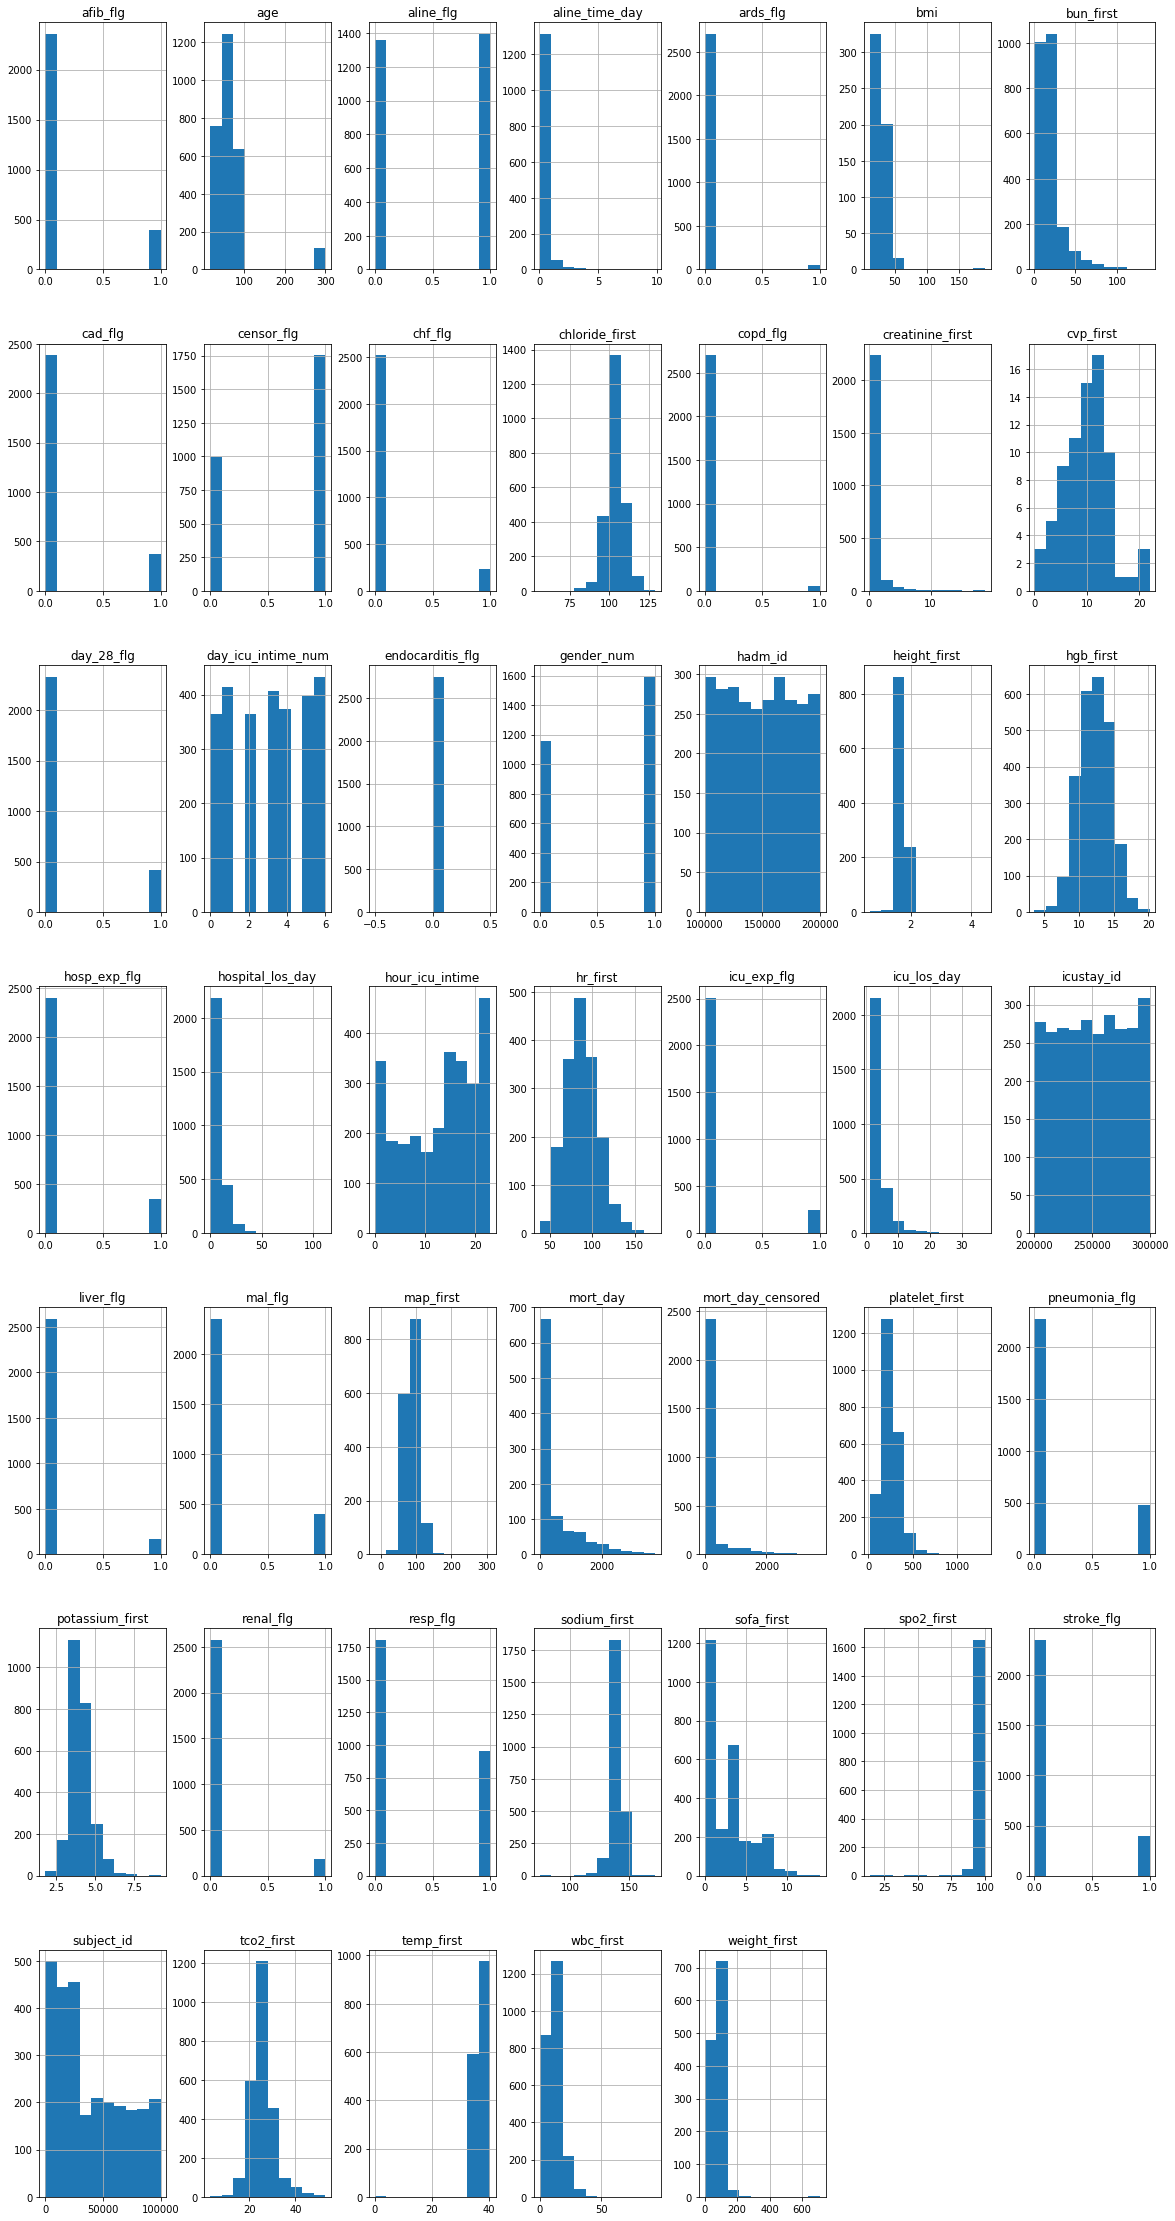

In [20]:
p = df.hist(figsize=(20,40))

In [55]:
df = pd.read_csv('aline-dataset.csv')

outcome = 'day_28_flg'
preds = ['age','gender_num','day_icu_intime_num','hour_icu_intime','aline_flg','aline_time_day','weight_first','height_first','bmi','service_unit','sofa_first','map_first','hr_first','temp_first','spo2_first','cvp_first','bun_first','creatinine_first','chloride_first','hgb_first','platelet_first','potassium_first','sodium_first','tco2_first','wbc_first','chf_flg','afib_flg','renal_flg','liver_flg','copd_flg','cad_flg','stroke_flg','mal_flg','resp_flg','endocarditis_flg','ards_flg','pneumonia_flg']
#preds = ['age','gender_num','day_icu_intime_num','hour_icu_intime','aline_flg','aline_time_day','weight_first','height_first','bmi','service_unit','sofa_first','map_first','hr_first','temp_first','spo2_first','cvp_first','bun_first','creatinine_first','chloride_first','hgb_first','platelet_first','potassium_first','sodium_first','tco2_first','wbc_first']

X = df[preds]
X = pd.get_dummies(X, columns=['service_unit'])
X = X.fillna(X.mean())

y = df[outcome]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

clf = LogisticRegression(penalty='none', solver='lbfgs', max_iter=30000).fit(X_train,y_train)
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.8362470142492382

In [56]:
from tqdm import tqdm

clf_LR = LogisticRegression(penalty='none', max_iter=10000)
clf_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=3000)
clf_RF = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf_XGB = xgb.XGBClassifier(learning_rate=0.1)

clf_list = [clf_LR, clf_lasso, clf_RF, clf_XGB]
clf_name_list = ['Logistic regression', 'lasso', 'Random forest', 'XGB']

for clf in tqdm(clf_list):
    clf.fit(X_train, y_train)

100%|██████████| 4/4 [00:03<00:00,  1.15it/s]


## 3. ROC, PRC, and DC plots

In [57]:
def plot_roc(clf, name):
    y_pred = clf.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresh = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label='{} ({:.3f})'.format(name, roc_auc))
    
def plot_prc(clf, name):
    y_pred = clf.predict_proba(X_test)[:,1]
    precision, recall, thresh = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label='{} ({:.3f})'.format(name, pr_auc))

def plot_dc(clf, name):
    y_prob = clf.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    tn = np.copy(thresholds)
    fp = np.copy(thresholds)
    fn = np.copy(thresholds)
    tp = np.copy(thresholds)

    for i in range(len(thresholds)):
        y_pred = [1 if p >= thresholds[i] else 0 for p in y_prob]
        tn[i], fp[i], fn[i], tp[i] = confusion_matrix(y_test, y_pred).ravel()

    n = len(y_test)
    nb = tp / n - fp / n * (thresholds / (1-thresholds+1e-5)) #netbenefit
    for i in range(len(thresholds)):
        if nb[i] <0:
            nb[i] = np.nan
    plt.plot(thresholds, nb, label='{}'.format(name))

def plot_calibration_curve(clf, name):
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, clf.predict_proba(X_test)[:,1], n_bins=10, strategy='quantile')
    observed = fraction_of_positives * len(y_test)/10
    expected = mean_predicted_value * len(y_test)/10
    cs, p = chisquare(observed, expected, 1)
    if p >= 1:
        disp_p = 'P=1.00'
    elif p >=0.01:
        disp_p = f'P={p:.02f}'
    elif p >=0.001:
        disp_p = f'P={p:.03f}'
    else:
        disp_p = 'P<0.001'
    plt.plot(mean_predicted_value, fraction_of_positives, label=f'{name} ({disp_p})', marker='.')
    #plt.plot(mean_predicted_value, fraction_of_positives, label=f'{name}', marker='.')

divide by zero encountered in true_divide


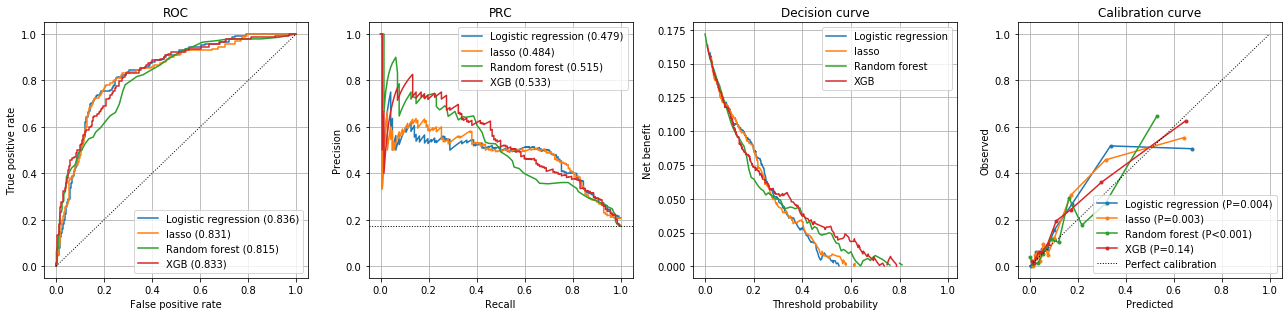

In [58]:
plt.figure(figsize=(4.5*4,4.5))

plt.subplot(1, 4, 1)
[plot_roc(x[0], x[1]) for x in zip(clf_list, clf_name_list)]
plt.plot([0, 1], [0, 1], linestyle='dotted', linewidth=1, color='black')
plt.grid()
plt.title('ROC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

plt.subplot(1, 4, 2)
[plot_prc(x[0], x[1]) for x in zip(clf_list, clf_name_list)]
prev = np.sum(y_test)/len(y_test)
plt.plot([-0.05, 1.05], [prev, prev], linestyle='dotted', linewidth=1, color='black')
plt.grid()
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.title('PRC')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')

plt.subplot(1, 4, 3)
[plot_dc(x[0], x[1]) for x in zip(clf_list, clf_name_list)]
plt.grid()
plt.title('Decision curve')
plt.xlabel('Threshold probability')
plt.ylabel('Net benefit')
plt.legend(loc='upper right')

plt.subplot(1, 4, 4)
[plot_calibration_curve(x[0], x[1]) for x in zip(clf_list, clf_name_list)]
plt.grid()
plt.title('Calibration curve')
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.plot([0, 1], [0, 1], linestyle='dotted', linewidth=1, color='black', label='Perfect calibration')
plt.legend(loc='lower right')

plt.tight_layout()

plt.savefig('datathon_plots.png', dpi=300)

## 4. Performance measures and 95% confidence intervals

In [59]:
def performance_measure(clf, X, y, threshold):
    y_prob = clf.predict_proba(X)[:,1]
    roc_auc = roc_auc_score(y, y_prob)

    precision, recall, thresholds = precision_recall_curve(y, y_prob)
    pr_auc = auc(recall, precision)

    y_pred = [1 if p >= threshold else 0 for p in y_prob]
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    n = len(y)
    nb = tp / n - fp / n * (threshold / (1-threshold)) #netbenefit
    if (nb<0):
        nb = np.nan
    sens = tp / (tp + fn)
    spec = tn / (fp + tn)
    ppv = tp / (tp + fp)
    npv = (tn+0.0001) / (tn + fn + 0.0001)
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    f1 = 2*ppv*sens/(ppv+sens)

    return roc_auc, pr_auc, f1, sens, spec, ppv, npv, accuracy, nb

def calculate_performance_measures(clf, name, nbs=200, threshold=0, alpha=0.05):        
    roc_auc = np.copy([0.1]*nbs)
    pr_auc = np.copy([0.1]*nbs)
    f1 = np.copy([0.1]*nbs)
    sens = np.copy([0.1]*nbs)
    spec = np.copy([0.1]*nbs)
    ppv = np.copy([0.1]*nbs)
    npv = np.copy([0.1]*nbs)
    accuracy = np.copy([0.1]*nbs)
    nb = np.copy([0.1]*nbs)

    y_prob = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, drop_intermediate=False)
    J_stats = tpr - fpr
    i = np.argmax(J_stats)
    optimal_threshold = thresholds[i]
    thresholds = np.append(thresholds, 0)       
    if threshold==0:
        threshold = optimal_threshold

    np.random.seed(seed=32)
    random_states = np.random.randint(0, len(y_test), size=nbs)

    for i in range(nbs):
        X, y = resample(X_test, y_test, random_state = random_states[i])
        roc_auc[i], pr_auc[i], f1[i], sens[i], spec[i], ppv[i], npv[i], accuracy[i], nb[i] = performance_measure(clf, X, y, threshold)

    df_performance = pd.DataFrame(
        np.array([roc_auc, pr_auc, f1, sens, spec, ppv, npv, accuracy, nb]).T, 
        columns=['ROC-AUC', 'PR-AUC', 'F1', 'sens', 'spec', 'ppv', 'npv', 'accu', 'nb']
    )

    l = alpha/2
    c = 0.5
    u = 1-alpha/2
    cis = df_performance.quantile([l, c, u])
    d = [name, threshold]
    for col in df_performance.columns:
        lcu = cis[col]
        x = '{:.3f} ({:.3f} - {:.3f})'.format(lcu[c], lcu[l], lcu[u])
        d.append(x)

    cols = ['model', 'P_t']
    cols.extend(df_performance.columns)

    ci = pd.DataFrame([d], columns=cols)

    return ci

In [60]:
df_performance_list = [calculate_performance_measures(x[0], x[1]) for x in zip(clf_list, clf_name_list)]
pd.concat(df_performance_list)

,model,P_t,ROC-AUC,PR-AUC,F1,sens,spec,ppv,npv,accu,nb
0,Logistic regression,0.161240,0.836 (0.803 - 0.867),0.482 (0.407 - 0.560),0.578 (0.523 - 0.642),0.731 (0.651 - 0.811),0.836 (0.809 - 0.863),0.478 (0.410 - 0.554),0.938 (0.917 - 0.957),0.817 (0.794 - 0.844),0.098 (0.078 - 0.128)
0,lasso,0.123507,0.830 (0.798 - 0.860),0.481 (0.407 - 0.562),0.556 (0.505 - 0.617),0.783 (0.718 - 0.850),0.789 (0.763 - 0.819),0.435 (0.382 - 0.500),0.946 (0.927 - 0.963),0.788 (0.766 - 0.815),0.110 (0.087 - 0.138)
0,Random forest,0.160000,0.813 (0.778 - 0.850),0.521 (0.437 - 0.594),0.494 (0.434 - 0.552),0.784 (0.720 - 0.849),0.712 (0.675 - 0.744),0.363 (0.304 - 0.414),0.940 (0.921 - 0.959),0.724 (0.696 - 0.754),0.089 (0.063 - 0.116)
0,XGB,0.094224,0.835 (0.791 - 0.868),0.535 (0.441 - 0.615),0.511 (0.451 - 0.568),0.831 (0.772 - 0.883),0.707 (0.672 - 0.737),0.369 (0.313 - 0.420),0.952 (0.935 - 0.969),0.728 (0.695 - 0.755),0.119 (0.094 - 0.143)


## 5. Model interpretation by SHAP

In [126]:
import shap
shap.initjs()

clf = clf_RF

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [133]:
def display_predicted_probability(i):
    display(X_test.iloc[[i],:])
    print(f'predicted probability = {y_prob[i]}')
    return shap.force_plot(explainer.expected_value[1], shap_values[1][i,:],X_test.iloc[i,:])
    
display_predicted_probability(np.random.randint(0, len(X_test)))

,age,gender_num,day_icu_intime_num,hour_icu_intime,aline_flg,aline_time_day,weight_first,height_first,bmi,sofa_first,map_first,hr_first,temp_first,spo2_first,cvp_first,bun_first,creatinine_first,chloride_first,hgb_first,platelet_first,potassium_first,sodium_first,tco2_first,wbc_first,chf_flg,afib_flg,renal_flg,liver_flg,copd_flg,cad_flg,stroke_flg,mal_flg,resp_flg,endocarditis_flg,ards_flg,pneumonia_flg,service_unit_CMED,service_unit_DENT,service_unit_ENT,service_unit_GU,service_unit_GYN,service_unit_MED,service_unit_NMED,service_unit_NSURG,service_unit_OBS,service_unit_OMED,service_unit_ORTHO,service_unit_PSURG,service_unit_SURG,service_unit_TRAUM
1877,18.328813,1,0,10,1,0.172697,80.716658,1.699925,29.079572,0,87.407245,87.905848,36.655078,100.0,10.013333,23.0,1.1,104.0,12.2,354.0,3.3,143.0,23.0,18.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


predicted probability = 0.0


In [134]:
display_predicted_probability(np.random.randint(0, len(X_test)))

,age,gender_num,day_icu_intime_num,hour_icu_intime,aline_flg,aline_time_day,weight_first,height_first,bmi,sofa_first,map_first,hr_first,temp_first,spo2_first,cvp_first,bun_first,creatinine_first,chloride_first,hgb_first,platelet_first,potassium_first,sodium_first,tco2_first,wbc_first,chf_flg,afib_flg,renal_flg,liver_flg,copd_flg,cad_flg,stroke_flg,mal_flg,resp_flg,endocarditis_flg,ards_flg,pneumonia_flg,service_unit_CMED,service_unit_DENT,service_unit_ENT,service_unit_GU,service_unit_GYN,service_unit_MED,service_unit_NMED,service_unit_NSURG,service_unit_OBS,service_unit_OMED,service_unit_ORTHO,service_unit_PSURG,service_unit_SURG,service_unit_TRAUM
2654,22.956414,0,3,15,1,0.326192,80.716658,0.91,29.079572,1,87.407245,87.905848,36.655078,98.409624,10.013333,15.0,0.6,98.0,11.0,134.0,3.4,146.0,41.0,32.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


predicted probability = 0.06


In [135]:
display_predicted_probability(np.random.randint(0, len(X_test)))

,age,gender_num,day_icu_intime_num,hour_icu_intime,aline_flg,aline_time_day,weight_first,height_first,bmi,sofa_first,map_first,hr_first,temp_first,spo2_first,cvp_first,bun_first,creatinine_first,chloride_first,hgb_first,platelet_first,potassium_first,sodium_first,tco2_first,wbc_first,chf_flg,afib_flg,renal_flg,liver_flg,copd_flg,cad_flg,stroke_flg,mal_flg,resp_flg,endocarditis_flg,ards_flg,pneumonia_flg,service_unit_CMED,service_unit_DENT,service_unit_ENT,service_unit_GU,service_unit_GYN,service_unit_MED,service_unit_NMED,service_unit_NSURG,service_unit_OBS,service_unit_OMED,service_unit_ORTHO,service_unit_PSURG,service_unit_SURG,service_unit_TRAUM
846,46.732814,0,2,18,0,0.308651,75.1,1.699925,29.079572,7,74.0,97.0,36.777778,100.0,10.013333,17.0,0.7,105.0,12.6,390.0,3.7,138.0,25.0,20.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


predicted probability = 0.07


In [136]:
display_predicted_probability(np.random.randint(0, len(X_test)))

,age,gender_num,day_icu_intime_num,hour_icu_intime,aline_flg,aline_time_day,weight_first,height_first,bmi,sofa_first,map_first,hr_first,temp_first,spo2_first,cvp_first,bun_first,creatinine_first,chloride_first,hgb_first,platelet_first,potassium_first,sodium_first,tco2_first,wbc_first,chf_flg,afib_flg,renal_flg,liver_flg,copd_flg,cad_flg,stroke_flg,mal_flg,resp_flg,endocarditis_flg,ards_flg,pneumonia_flg,service_unit_CMED,service_unit_DENT,service_unit_ENT,service_unit_GU,service_unit_GYN,service_unit_MED,service_unit_NMED,service_unit_NSURG,service_unit_OBS,service_unit_OMED,service_unit_ORTHO,service_unit_PSURG,service_unit_SURG,service_unit_TRAUM
2480,86.548188,0,5,0,1,0.425,80.716658,1.699925,29.079572,3,92.0,99.0,38.166665,100.0,10.013333,14.0,0.8,93.0,15.0,275.0,4.1,135.0,23.0,17.8,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


predicted probability = 0.65


In [132]:
display_predicted_probability(np.random.randint(0, len(X_test)))

,age,gender_num,day_icu_intime_num,hour_icu_intime,aline_flg,aline_time_day,weight_first,height_first,bmi,sofa_first,map_first,hr_first,temp_first,spo2_first,cvp_first,bun_first,creatinine_first,chloride_first,hgb_first,platelet_first,potassium_first,sodium_first,tco2_first,wbc_first,chf_flg,afib_flg,renal_flg,liver_flg,copd_flg,cad_flg,stroke_flg,mal_flg,resp_flg,endocarditis_flg,ards_flg,pneumonia_flg,service_unit_CMED,service_unit_DENT,service_unit_ENT,service_unit_GU,service_unit_GYN,service_unit_MED,service_unit_NMED,service_unit_NSURG,service_unit_OBS,service_unit_OMED,service_unit_ORTHO,service_unit_PSURG,service_unit_SURG,service_unit_TRAUM
2424,77.179675,1,4,6,0,0.308651,80.716658,1.699925,29.079572,0,87.407245,87.905848,36.655078,98.409624,10.013333,23.0,1.0,97.0,12.0,431.0,6.1,134.0,28.0,13.8,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


predicted probability = 0.21


In [46]:
sv_sampled, X_sampled = resample(shap_values, df_X, n_samples=50, random_state=0)
shap.force_plot(explainer.expected_value, sv_sampled, X_sampled)

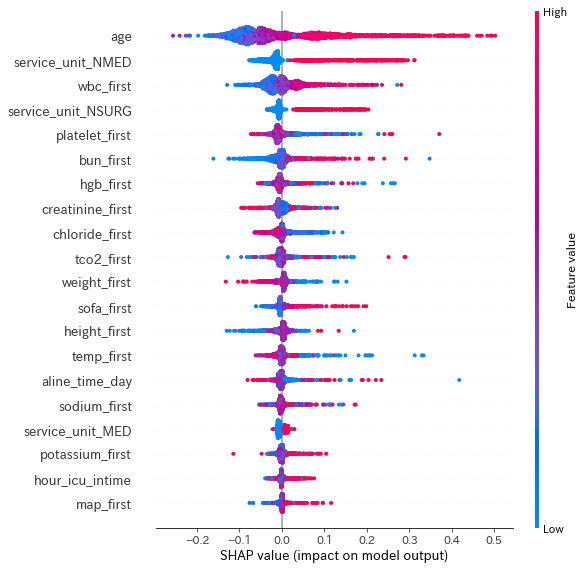

In [13]:
import japanize_matplotlib
shap.summary_plot(shap_values, df_X)

In [14]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(df_X)

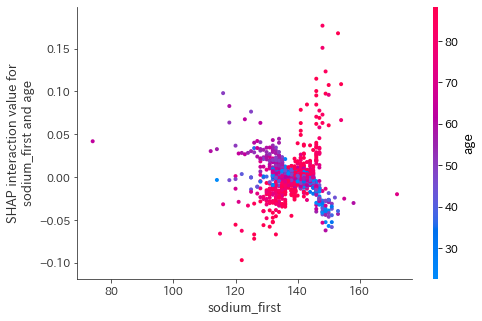

In [18]:
shap.dependence_plot(('sodium_first', 'age'), shap_interaction_values, df_X, interaction_index='age')

## 6. XGBoost early stopping round

In [184]:
import xgboost as xgb

gbm_params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'learning_rate':0.1,
            'max_depth':4,
            #'reg_lambda':0,
            'reg_alpha':0.05,
            'n_estimators':200,
            'min_child_weight':5,
            'gamma':0,
            'subsample':0.8,
            'colsample_bytree':0.80
        }

X = pd.get_dummies(df[preds], columns=['service_unit']).values
y = df[outcome].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

clf = xgb.XGBClassifier(**gbm_params)

evals_result = {}
clf.fit(
    X_train, y_train, 
    eval_set=[
        (X_train, y_train),
        (X_test, y_test),
    ],
    early_stopping_rounds=10,
    callbacks=[
        xgb.callback.record_evaluation(evals_result)
    ],
    verbose=False
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='logloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

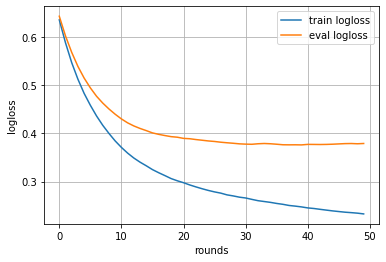

In [185]:
train_metric = evals_result['validation_0']['logloss']
plt.plot(train_metric, label='train logloss')
eval_metric = evals_result['validation_1']['logloss']
plt.plot(eval_metric, label='eval logloss')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('logloss')
plt.show()

In [186]:
y_prob = clf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_prob)

0.7958570134255828

In [187]:
y_pred = clf.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

0.9294622589531681